<a href="https://colab.research.google.com/github/Enry6tz/PracticasPy/blob/main/Clasificacion_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales para Reconocimiento de Números en Imágenes

* Peñafort Raimundo
* Seitz Enrique

In [48]:
# Importar las bibliotecas necesarias
from tensorflow import keras
import numpy as np
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2


## Introducción
Vamos a utilizar un dataset público de imágenes de números de casas obtenidas de Google Street View, *Street View House Numbers (SVHN)*, y vamos a construir un clasificador que identifique qué número se muestra en cada imagen. Este dataset consiste en imágenes RGB de 32x32 píxeles en los que cada imagen corresponde a un dígito (0-9) recortado de una foto del número de una casa. Nuestra red neuronal tendrá que ser capaz de distinguir por lo tanto entre 10 clases posibles.

![](https://drive.google.com/uc?export=view&id=1AxXIEAXnM-xgqS_i5dquKdzXQWJEDWc9)

## Preparación del dataset

En primer lugar descargamos las imágenes

In [2]:
!wget 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
!wget 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'

--2023-10-17 20:39:43--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  43.3MB/s    in 1.4s    

2023-10-17 20:39:45 (43.3 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

--2023-10-17 20:39:45--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  68.9MB/s    in 2.5s    

2023-10-17 20:39:47 (68.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182

>Leemos los ficheros como numpy arrays. Por defecto los arrays tienen dimensiones (ancho, alto, # canales, # imágenes), pero para nuestro modelo el número de imágenes sera la primera dimensión.

* establecemos una semilla (seed) para la generación de números aleatorios, lo que asegura que nuestros resultados sean reproducibles.

* A continuación, cargamos los datos del conjunto de entrenamiento y prueba desde los archivos MAT descargados previamente. Los datos se almacenan en las variables train_data y test_data.

Finalmente, reorganizamos las imágenes para que el primer eje represente el número de imágenes. Esta reorganización es necesaria para que los datos sean compatibles con la arquitectura de las redes neuronales convolucionales (CNN) que utilizaremos en nuestro proyecto.

In [ ]:
np.random.seed(10)
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

train_images = np.array(train_data['X'])
test_images = np.array(test_data['X'])
train_labels = train_data['y']
test_labels = test_data['y']
# We set the number of images as the first axis
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

* Además, las etiquetas vienen dadas como 1-10, con el 10 correspondiendo a una imagen de 0. Lo vamos a cambiar, y también a transformar estas etiquetas en categóricas (aunque podríamos usar también las etiquetas numéricas cambiando la *loss function* al entrenar el modelo).
* Luego, se convierten las etiquetas en un formato conocido como "one-hot encoding" utilizando la función to_categorical de la biblioteca Keras de TensorFlow. El one-hot encoding es una técnica de representación de etiquetas que convierte etiquetas categóricas en vectores binarios, donde un único valor es 1 (caliente) y todos los demás son 0 (fríos). Esto es esencial para entrenar redes neuronales, ya que les permite comprender y aprender de manera efectiva las relaciones entre las clases.

In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

El trainset está compuesto de más de 73000 imágenes, son bastantes para 10 clases, pero podemos también hacer *data augmentation para tener más variedad* y que nuestro modelo sea más robusto. Usamos *ImageDataGenerator* de *tf.keras* para algunas modificaciones sencillas. En este caso, vamos a rotar las imágenes, añadir (o quitar) zoom, cambiar el brillo y la intensidad de los canales, e inclinarlas.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.1,
                             shear_range=0.1,
                             channel_shift_range=0.1,
                             brightness_range=[0.95, 1.05])

# Construyendo la CNN
>En primer lugar construimos nuestro propio modelo con la API funcional. El funcionamiento es bastante simple: dado un input, vamos a hacer actuar una capa sobre este, al output de esta operación le aplicaremos la siguiente capa, y así sucesivamente. Para nuestro caso, podemos dividir la red en dos partes: una parte de *feature extraction* compuesta por capas convolucionales y pooling que extrae las características de la imagen, y un *clasificador* que pesa estas características para dar la predicción.

*feature extraction*
1. Se crea una capa de entrada `inputs` con una forma de (32, 32, 3) para acomodar imágenes de 32x32 píxeles con 3 canales (RGB).

2. Se define una función `block` que se utilizará para construir bloques repetitivos en la CNN. Cada bloque consiste en una capa convolucional, una capa de activación 'swish', y opcionalmente una capa de dropout para regularizar el modelo.

3. Se inicia la "etapa de inicio" de la CNN con una capa convolucional que tiene 32 filtros, activación 'swish', y se aplica una normalización por lotes (BatchNormalization) y una activación 'swish'.

4. Se define el "cuerpo principal" de la CNN, que consta de una serie de bloques repetitivos con un número creciente de filtros en cada bloque. Cada bloque incluye una capa convolucional, activación 'swish', max-pooling y, en algunos casos, dropout para evitar el sobreajuste.

5. Luego, se agrega una capa de Global Average Pooling (GAP), que reduce la dimensión de las características finales de la CNN.

6. Se aplica una capa de dropout para regularizar el modelo y, finalmente, una capa densa con 10 neuronas de salida y activación softmax, que representa las 10 clases posibles (números del 0 al 9).

7. Se crea el modelo completo especificando las capas de entrada y salida.

In [ ]:
from tensorflow.keras import layers, Model, optimizers
# Capa de entrada con la forma de nuestras imágenes.
inputs = layers.Input(shape=(32, 32, 3))

# Repetiremos este bloque para diferentes números de filtros, para que podamos definirlo primero
i=0
def block(inputs, filters, size, drop_out=None):
    global i
    i += 1
    x = layers.Conv2D(filters, size, padding='same',
                        activation='swish',
                        name=f'conv{i}')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    if drop_out != None:
        x = layers.Dropout(drop_out)(x)
    return x
# Definimos el "tallo" de la cnn con una capa convolucional con 32 filtros
# La activación es 'swish', que suele funcionar mejor que el "relu" más común
x = layers.Conv2D(32, (3, 3), padding='same',
                       activation='swish',
                       input_shape=(32, 32, 3),
                       name ='stem_conv2d')(inputs)
x = layers.BatchNormalization(name='stem_bn')(x)
x = layers.Activation('swish', name='stem_activation')(x)

#main "cuerpo de la cnn"
for i in range(5, 10):
    if i<9:
        x = block(x, np.power(2,i), (3,3), drop_out=0.2)
    else:
        x = block(x, np.power(2,i), (3,3))

# Clasificador, aquí usamos GlobalAveragePooling en lugar de aplanar la salida
# ya que también permite reducir # parámetros
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

# Finalmente, definimos el modelo especificando la entrada y la salida.
model = Model(inputs, outputs, name='Custom_model')

In [50]:
from IPython.display import Image

Image(url="https://miro.medium.com/v2/resize:fit:363/1*gBdEHDWWQhm9sjH3m7mBMg.png")


Podemos ver la estructura de capas, así como el número de parámetros de este modelo

In [ ]:
model.summary()

Model: "Custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stem_conv2d (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 stem_bn (BatchNormalizatio  (None, 32, 32, 32)        128       
 n)                                                              
                                                                 
 stem_activation (Activatio  (None, 32, 32, 32)        0         
 n)                                                              
                                                                 
 conv6 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)       

Además de las capas mencionadas antes, hemos añadido algunas otras que, aunque no son estrictamente necesarias, mejoran el comportamiento del modelo:

- **BatchNormalization**: normaliza las imágenes del batch y mejora la capacidad de generalización de la red además de ofrecer un pequeño efecto regularizador.
- **Dropout**: pone a 0 algunas de las neuronas para prevenir overfitting.

Además, para reducir el número de capas densas (y por lo tanto de parámetros), hemos introducido un GlobalAveragePooling en el clasificador.

El siguiente paso es compilar el modelo. Elegimos Adam como *optimizer* (que se encarga de actualizar los pesos en cada iteración), categorical crossentropy como *loss function* y el % de acierto como métrica.

Con esta configuración, el modelo está listo para ser entrenado utilizando el conjunto de datos de entrenamiento y evaluado utilizando el conjunto de datos de prueba. El optimizador Adam ajustará los parámetros del modelo para minimizar la función de pérdida, y la precisión se utilizará como una métrica para medir el rendimiento del modelo.

In [ ]:
optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                           metrics=["accuracy"])

Definimos una función auxiliar que nos permita visualizar el error y el % de acierto tanto en el trainset como en el testset durante el entrenamiento.

In [ ]:

def plot_hist(hist, name):
        """Plots training chart"""
        plt.figure(figsize=[12, 10])
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title(f"{name}")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.ylim(top=1.1)
        plt.legend(["train_acc", "validation_acc", "train_loss", "validation_loss"], loc="upper left")
        plt.savefig(f'{name}_chart.png')
        plt.show()

Vamos a utilizar algunos callbacks que ofrece tf.keras. Los callbacks nos permiten realizar algunas acciones durante el entrenamiento. En particular, y fijándonos en el error en el testset, vamos a guardar el modelo después de cada epoch, pero sólo si mejora el mejor valor hasta el momento. También añadimos early stopping, para parar el entrenamiento si no mejora durante 4 epochs, y reducimos el learning rate si este se estanca.

In [ ]:
import os
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
# Detener el entrenamiento si val_loss no disminuye en cuatro épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4, restore_best_weights=True)
# guardar el mejor modelo indicando la época
model_save = ModelCheckpoint('./weights/Custom_model_{epoch}.h5',
                             save_best_only=True, monitor='val_loss', verbose=1)
# Carpeta para guardar pesos
if not os.path.exists('./weights'):
    os.makedirs('./weights', mode=0o770, exist_ok=True)

# reducir la tasa de aprendizaje si val_loss no disminuye en 2 épocas, tiempo de reutilización de 1 época
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)

Finalmente utilizamos el método fit para entrenar el modelo. En caso de necesitar algo más sofisticado, tf.keras también da la opción de escribir un loop de entrenamiento personalizado (sólo mostramos las últimas lineas del output).

In [ ]:
hist = model.fit(datagen.flow(train_images, train_labels, batch_size=128), epochs=9, validation_data=(test_images, test_labels), verbose=1,
                         callbacks=[model_save, reduce_lr, early_stopping])

# Guardar el modelo en un archivo HDF5
model.save('mi_modelo9.h5')

Epoch 1/9
573/573 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.6754
Epoch 1: val_loss improved from inf to 0.40626, saving model to ./weights/Custom_model_1.h5
573/573 [==============================] - 954s 2s/step - loss: 0.9701 - accuracy: 0.6754 - val_loss: 0.4063 - val_accuracy: 0.8740 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/9
573/573 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8629
Epoch 2: val_loss improved from 0.40626 to 0.25929, saving model to ./weights/Custom_model_2.h5
573/573 [==============================] - 975s 2s/step - loss: 0.4393 - accuracy: 0.8629 - val_loss: 0.2593 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 3/9
573/573 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8862
Epoch 3: val_loss improved from 0.25929 to 0.23566, saving model to ./weights/Custom_model_3.h5
573/573 [==============================] - 947s 2s/step - loss: 0.3677 - accuracy: 0.8862 - val_loss: 0.2357 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 4/9
573/573 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8991
Epoch 4: val_loss improved from 0.23566 to 0.23400, saving model to ./weights/Custom_model_4.h5
573/573 [==============================] - 957s 2s/step - loss: 0.3317 - accuracy: 0.8991 - val_loss: 0.2340 - val_accuracy: 0.9345 - lr:

Alcanzamos un 94.96% de acierto. Y podemos ver la evolución de las métricas

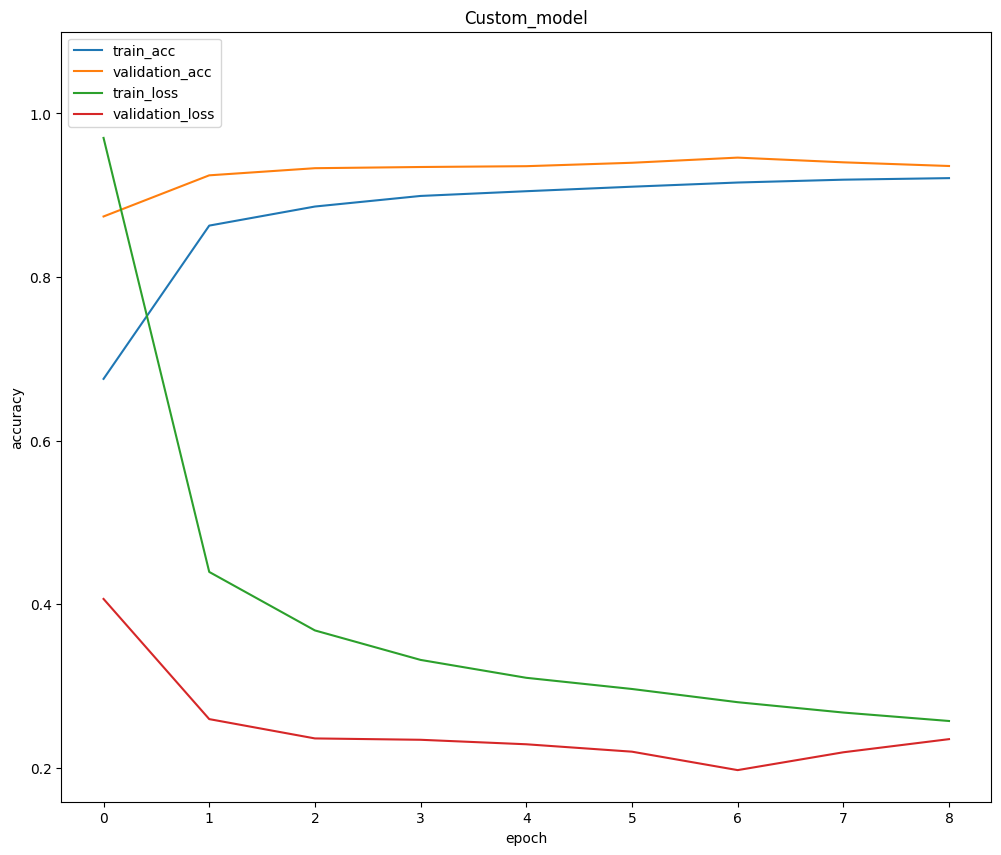

In [ ]:
plot_hist(hist, name='Custom_model')

También podemos calcular la matriz de confusión con ayuda de otra función auxiliar

In [ ]:
def conf_matrix(model, samples, y_true, name):
    classes = np.arange(0,10)
    y_pred = model.predict(samples)
    pred_test = np.argmax(y_pred, axis=1)
    true_test = np.argmax(y_true, axis=1)
    array = confusion_matrix(true_test, pred_test)
    df_cm = pd.DataFrame(array, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,8))
    #ticks = np.arange(df_cm.values.min(), df_cm.values.max()+1 )
    cmap = plt.get_cmap("YlOrRd", df_cm.values.max() - df_cm.values.min()+1)
    sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='d', annot_kws={'clip_box':'tight'})
    plt.ylabel('True', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'Conf_matrix_{name}.png', bbox_inches='tight', dpi=300, transparent=False)

814/814 [==============================] - 53s 65ms/step


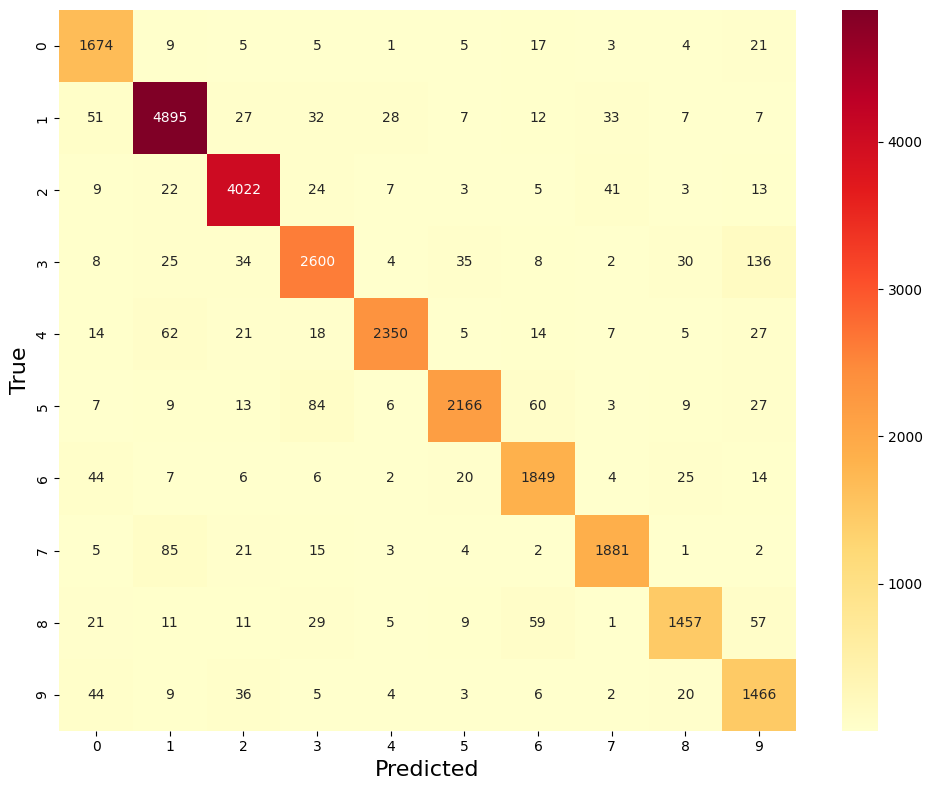

In [ ]:
conf_matrix(model, test_images, test_labels, 'Custom_model_test')

In [8]:

# Cargar el modelo desde el archivo HDF5
model = keras.models.load_model('/content/sample_data/mi_modelo9.h5')



In [9]:
def preprocess_image(image):
    # Realiza el preprocesamiento aquí, por ejemplo, cambiar el tamaño y normalizar la imagen
    resized_image = cv2.resize(image, (32, 32))  # Ajusta el ancho y alto según tu modelo
    return resized_image

In [45]:


# Cargar la nueva imagen y preprocesarla (ajusta esto según tu modelo)
new_image = cv2.imread('/content/sample_data/7a.png')
preprocessed_image = preprocess_image(new_image)

# Agregar una dimensión para simular un lote de una sola imagen
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Realizar una predicción en la imagen
predicted_class = model.predict(preprocessed_image_batch)

# El resultado de la predicción será un vector de probabilidades o valores que corresponden a las clases. Puedes interpretarlo para obtener la etiqueta de clase predicha.
predicted_label = int(np.argmax(predicted_class))
print(predicted_class)
print ("prediccion: ", predicted_label)


1/1 [==============================] - 0s 32ms/step
[[6.8020017e-04 9.4398223e-03 8.7666459e-02 8.1126345e-03 4.0842384e-02
  1.7811968e-04 2.7393343e-04 8.4726232e-01 3.1221723e-03 2.4219446e-03]]
prediccion:  7


Como cabía esperar, algunos números se confunden más fácilmente con otros, así los sietes se confunden más con unos, los ochos con seises y los nueves con ceros, por ejemplo.

Además, el dataset SVHN tiene más de 500.000 imágenes extra, que clasifican como "más sencillas". Podemos usarlas también como un test extra.

In [ ]:
!wget 'http://ufldl.stanford.edu/housenumbers/extra_32x32.mat'
extra_data = loadmat('extra_32x32.mat')

extra_images = np.array(extra_data['X'])
extra_labels = extra_data['y']

extra_images = np.moveaxis(extra_images, -1, 0)

extra_labels[extra_labels == 10] = 0
extra_labels = to_categorical(extra_labels)

In [ ]:
model.evaluate(extra_images, extra_labels)

16598/16598 [==============================] - 1090s 66ms/step - loss: 0.1126 - accuracy: 0.9685


[0.11262041330337524, 0.9685388207435608]

16598/16598 [==============================] - 1079s 65ms/step


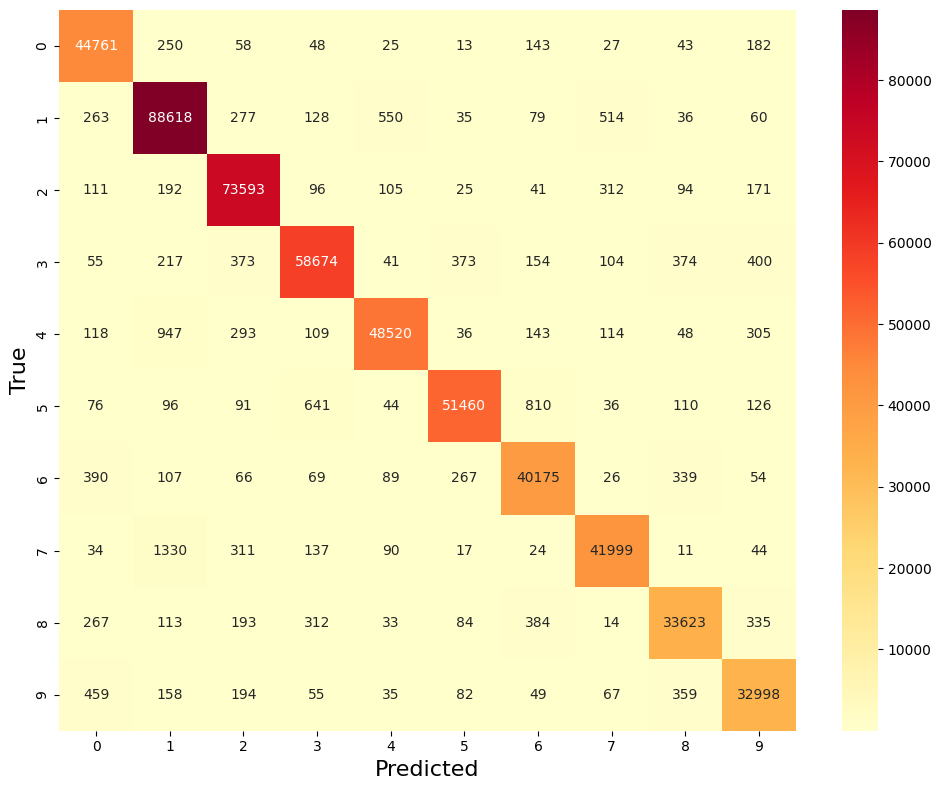

In [ ]:
conf_matrix(model, extra_images, extra_labels, 'Custom_model_extra')

## Conclusiones

En general, este proyecto ha demostrado cómo implementar y entrenar una red neuronal convolucional personalizada en un conjunto de datos del mundo real. Además, hemos explorado técnicas de preprocesamiento, diseño de arquitectura, entrenamiento y evaluación del modelo. Los resultados sólidos obtenidos en la clasificación de dígitos manuscritos confirman la eficacia de la arquitectura de la CNN y subrayan la importancia de las estrategias de regularización y optimización. Este proyecto proporciona una sólida base para futuras investigaciones y aplicaciones de aprendizaje profundo en la clasificación de imágenes.